# 案例：信用卡交易欺诈数据预测

### 1 背景
#### 有一批交易数据，数据总量达到28万多条。其中，正常交易数据量占比99.83%，欺诈交易数据量仅占比0.17%，此案例属于一个典型的不平衡数据案例。

### 2 目标
#### 训练出一个模型，能够判断出欺诈交易数据。

### 方案二：
#### 采用SMOTE 技术来处理数据不平衡问题，SMOTE (Synthetic Minority Over-sampling Technique)，即：合成少数样本过采样技术
#### (1) 从少数类样本中，随机选择一个样本A；
#### (2) 确定k值（通常是k=5），找到该样本A最近的k个样本；
#### (3) 从该k个近邻样本中随机选择一个样本B；
#### (4) 生成的新样本为：样本A与样本B中间的一个随机点。

<<< 参考论文： SMOTE: Synthetic Minority Over-sampling Technique >>>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 加载数据文件
df = pd.read_csv("creditcard.csv")

In [3]:
df.shape

(284807, 31)

In [4]:
# 数据表中的大多数列的数据已经归一化，接下来对Amount进行归一化
from sklearn.preprocessing import StandardScaler

df['scaled_amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1)) # 金额归一化
df['scaled_time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1)) # 时间归一化

df.drop(['Amount', 'Time'], axis=1, inplace=True) # 删除原始的数据列

In [5]:
print("正常交易数据：", df.loc[df['Class']==0].shape[0])
print("欺诈交易数据：", df.loc[df['Class']==1].shape[0])

正常交易数据： 284315
欺诈交易数据： 492


In [6]:
X = df.drop('Class', axis=1) # 数据集
y = df['Class'] # 标签

print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (284807, 30)
y shape :  (284807,)


### # 方法1：利用SMOTE解决数据不平衡

In [9]:
from imblearn.over_sampling import SMOTE

X_new_1, y_new_1 = SMOTE().fit_resample(X, y)

In [10]:
# 新的类分布
y_new_1.value_counts()

1    284315
0    284315
Name: Class, dtype: int64

In [11]:
X_new_1.shape # 数据集已经扩充

(568630, 30)

### 方法2：利用SMOTE+undersampling解决数据不平衡

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# over
over = SMOTE(sampling_strategy=0.1)

# under
under = RandomUnderSampler(sampling_strategy=0.5)

# pipeline
steps = [('o', over),('u', under)]

pipeline = Pipeline(steps=steps)

X_new_2, y_new_2 = pipeline.fit_resample(X, y)

In [13]:
# 新的类分布
y_new_2.value_counts()

0    56862
1    28431
Name: Class, dtype: int64

In [14]:
X_new_2.shape # 新的数据集

(85293, 30)

### 数据集分离：train  和 test

#### 方法1的数据集

In [15]:
from sklearn.model_selection import train_test_split

X_new_1_train, X_new_1_test, y_new_1_train, y_new_1_test = train_test_split(X_new_1, y_new_1)

# 数据集
X_new_1_train = X_new_1_train.values
X_new_1_test = X_new_1_test.values

# 标签
y_new_1_train = y_new_1_train.values
y_new_1_test = y_new_1_test.values

In [16]:
X_new_1_train.shape

(426472, 30)

In [17]:
X_new_1_test.shape

(142158, 30)

#### 方法2的数据集

In [18]:
X_new_2_train, X_new_2_test, y_new_2_train, y_new_2_test = train_test_split(X_new_2, y_new_2)

# 数据集
X_new_2_train = X_new_2_train.values
X_new_2_test = X_new_2_test.values

# 标签
y_new_2_train = y_new_2_train.values
y_new_2_test = y_new_2_test.values

In [19]:
X_new_2_train.shape

(63969, 30)

In [20]:
X_new_2_test.shape

(21324, 30)

### 模型训练

In [21]:
# 简单分类器实现
from sklearn.linear_model import LogisticRegression # 逻辑回归
from sklearn.linear_model import SGDClassifier      # 随机梯度
from sklearn.neighbors import KNeighborsClassifier  # K近邻
from sklearn.svm import SVC                         # 支撑向量机
from sklearn.tree import DecisionTreeClassifier     # 决策树
from sklearn.ensemble import RandomForestClassifier # 随机森林
from sklearn.model_selection import cross_val_score # 交叉验证计算accuracy
from sklearn.model_selection import GridSearchCV    # 网格搜索，获取最优参数
from sklearn.model_selection import StratifiedKFold # 交叉验证
from collections import Counter
# 评估指标
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier # 集成学习
from xgboost import XGBClassifier                   # 极限梯度提升树

classifiers = {
    'LogisticRegression':LogisticRegression(), # 逻辑回归
    "SVC":SVC(),                               # 支撑向量机
    "KNN":KNeighborsClassifier(),              # K近邻
    'DT':DecisionTreeClassifier(),             # 决策树
    'RFC':RandomForestClassifier(),            # 随机森林
    'Bagging':BaggingClassifier(),             # 集成学习bagging
    'SGD':SGDClassifier(),                     # 随机梯度
    'GBC':GradientBoostingClassifier(),        # 集成学习Gradient
    'xgb':XGBClassifier()                      # 极限梯度提升树
}

In [22]:
def accuracy_score(X_train, y_train):
    for key, classifier in classifiers.items(): # 遍历每一个分类器，分别训练、计算得分
        classifier.fit(X_train, y_train)
        training_score = cross_val_score(classifier, X_train, y_train, cv=5) # 5折交叉验证
        print("Classifier Name : ", classifier.__class__.__name__,"  Training Score ：", round(training_score.mean(), 2)*100,'%')

### 1 最简单的交叉验证

#### 方法1：训练交叉验证的结果

In [23]:
# 1.1 SMOTE
accuracy_score(X_new_1_train, y_new_1_train)

Classifier Name :  LogisticRegression   Training Score ： 95.0 %
Classifier Name :  SVC   Training Score ： 98.0 %
Classifier Name :  KNeighborsClassifier   Training Score ： 100.0 %
Classifier Name :  DecisionTreeClassifier   Training Score ： 100.0 %
Classifier Name :  RandomForestClassifier   Training Score ： 100.0 %
Classifier Name :  BaggingClassifier   Training Score ： 100.0 %
Classifier Name :  SGDClassifier   Training Score ： 95.0 %
Classifier Name :  GradientBoostingClassifier   Training Score ： 98.0 %
Classifier Name :  XGBClassifier   Training Score ： 100.0 %


#### 方法2：训练交叉验证的结果

In [25]:
# 1.2 SMOTE + under sampling
accuracy_score(X_new_2_train, y_new_2_train)

Classifier Name :  LogisticRegression   Training Score ： 96.0 %
Classifier Name :  SVC   Training Score ： 97.0 %
Classifier Name :  KNeighborsClassifier   Training Score ： 100.0 %
Classifier Name :  DecisionTreeClassifier   Training Score ： 99.0 %
Classifier Name :  RandomForestClassifier   Training Score ： 100.0 %
Classifier Name :  BaggingClassifier   Training Score ： 99.0 %
Classifier Name :  SGDClassifier   Training Score ： 96.0 %
Classifier Name :  GradientBoostingClassifier   Training Score ： 98.0 %
Classifier Name :  XGBClassifier   Training Score ： 100.0 %


### 2 网格搜索：获取最优超参数

In [29]:
# 网格搜索：获取最优超参数
# 1 LR
def LR_gs(X_train, y_train):
    # LR
    LR_param = {
        'penalty':['l1', 'l2'],
        'C':[0.001, 0.01, 0.1, 1, 10]
    }

    LR_gs = GridSearchCV(LogisticRegression(),param_grid=LR_param, n_jobs=-1, scoring='accuracy')
    LR_gs.fit(X_train, y_train)

    LR_estimators = LR_gs.best_estimator_ # 最优参数
    
    return LR_estimators

In [30]:
# 2 KNN
def KNN_gs(X_train, y_train):
    KNN_param = {
        'n_neighbors':list(range(2, 5, 1)),
        'algorithm':['auto','ball_tree','kd_tree','brute']
    }

    KNN_gs = GridSearchCV(KNeighborsClassifier(), param_grid=KNN_param, n_jobs=-1, scoring='accuracy')
    KNN_gs.fit(X_train, y_train)

    KNN_estimators = KNN_gs.best_estimator_ # 最优参数
    
    return KNN_estimators

In [31]:
# 3 SVC
def SVC_gs(X_train, y_train):
    SVC_param = {
        'C':[0.5, 0.7, 0.9, 1],
        'kernel':['rfb', 'poly', 'sigmod', 'linear']
    }

    SVC_gs = GridSearchCV(SVC(), param_grid=SVC_param, n_jobs=-1, scoring='accuracy')
    SVC_gs.fit(X_train, y_train)

    SVC_estimators = SVC_gs.best_estimator_ # 最优参数
    
    return SVC_estimators

In [32]:
# 4 DT
def DT_gs(X_train, y_train):
    DT_param = {
        'criterion':['gini', 'entropy'], # 衡量标准
        'max_depth':list(range(2, 5, 1)), # 树的深度
        'min_samples_leaf':list(range(3, 7, 1)) # 最小叶子节点数
    }

    DT_gs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, n_jobs=-1, scoring='accuracy')
    DT_gs.fit(X_train, y_train)

    DT_estimators = DT_gs.best_estimator_ # 最优参数
    
    return DT_estimators

In [33]:
# 5 RFC
def RFC_gs(X_train, y_train):
    RFC_param = {
        'n_estimators':[100, 150, 200], # 多少棵树
        'criterion':['gini', 'entropy'], # 衡量标准
        'max_depth':list(range(2,5,1)), # 树的深度
    }
    
    RFC_gs = GridSearchCV(RandomForestClassifier(), param_grid=RFC_param, n_jobs=-1, scoring='accuracy')
    RFC_gs.fit(X_train, y_train)
    
    RFC_estimators = RFC_gs.best_estimator_
    
    return RFC_estimators

In [34]:
# 6 Bag
def BAG_gs(X_train, y_train):
    BAG_param = {
        'n_estimators':[10, 15, 20]
    }
    
    BAG_gs = GridSearchCV(BaggingClassifier(), param_grid=BAG_param, n_jobs=-1, scoring='accuracy')
    BAG_gs.fit(X_train, y_train)
    
    BAG_estimators = BAG_gs.best_estimator_
    
    return BAG_estimators

In [35]:
# 7 SGD
def SGD_gs(X_train, y_train):
    SGD_param = {
        'penalty':['l2','l1'],
        'max_iter':[1000, 1500, 2000]
    }
    
    SGD_gs = GridSearchCV(SGDClassifier(), param_grid=SGD_param, n_jobs=-1, scoring='accuracy')
    SGD_gs.fit(X_train, y_train)
    
    SGD_estimators = SGD_gs.best_estimator_
    
    return SGD_estimators

In [36]:
# 8 xgb
def XGB_gs(X_train, y_train):
    XGB_param = {
        'max_depth':[3,4,5,6]
    }
    
    XGB_gs = GridSearchCV(XGBClassifier(), param_grid=XGB_param, n_jobs=-1, scoring='accuracy')
    XGB_gs.fit(X_train, y_train)
    
    XGB_estimators = XGB_gs.best_estimator_
    
    return XGB_estimators

### 方法1

In [38]:
# 采用新的数据集：X_new_1_train, y_new_1_train

# 模型交叉验证、训练，获取最优超参数

LR_best_estimator = LR_gs(X_new_1_train, y_new_1_train)

KNN_best_estimator = KNN_gs(X_new_1_train, y_new_1_train)

# SVC_best_estimator = SVC_gs(X_new_1_train, y_new_1_train)

DT_best_estimator = DT_gs(X_new_1_train, y_new_1_train)

RFC_best_estimator = RFC_gs(X_new_1_train, y_new_1_train)

BAG_best_estimator = BAG_gs(X_new_1_train, y_new_1_train)

SGD_best_estimator = SGD_gs(X_new_1_train, y_new_1_train)

XGB_best_estimator = XGB_gs(X_new_1_train, y_new_1_train)

### 方法2

In [39]:
# 采用新的数据集：X_new_2_train, y_new_2_train

# 模型交叉验证、训练，获取最优超参数

LR_best_estimator = LR_gs(X_new_2_train, y_new_2_train)

KNN_best_estimator = KNN_gs(X_new_2_train, y_new_2_train)

# SVC_best_estimator = SVC_gs(X_new_2_train, y_new_2_train)

DT_best_estimator = DT_gs(X_new_2_train, y_new_2_train)

RFC_best_estimator = RFC_gs(X_new_2_train, y_new_2_train)

BAG_best_estimator = BAG_gs(X_new_2_train, y_new_2_train)

SGD_best_estimator = SGD_gs(X_new_2_train, y_new_2_train)

XGB_best_estimator = XGB_gs(X_new_2_train, y_new_2_train)

In [44]:
# 预测新的数据集：X_new_test, y_new_test
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

result_df = pd.DataFrame(columns=['Accuracy', 'F1-score', 'Recall', 'Precision', 'AUC_ROC'],
                         index=['LR','KNN','DT','RFC','Bagging','SGD','XGB'])

def caculate(models, X_test, y_test):
    # 计算各种参数的值
    accuracy_results = []
    F1_score_results = []
    Recall_results = []
    Precision_results = []
    AUC_ROC_results = []
    
    for model in models:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) # 计算准确度
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred) # 计算：精确度，召回率，f1_score
        AUC_ROC = roc_auc_score(y_test, y_pred) # 计算ROC, AUC
        
        # 保存计算值
        accuracy_results.append(accuracy)
        F1_score_results.append(f1_score)
        Recall_results.append(recall)
        AUC_ROC_results.append(AUC_ROC)
        Precision_results.append(precision)
        
    return accuracy_results, F1_score_results, Recall_results, AUC_ROC_results, Precision_results

#### X_new_1_test, y_new_1_test

In [45]:
# 将所有最优超参数的模型放在一起
best_models = [LR_best_estimator, KNN_best_estimator, DT_best_estimator, RFC_best_estimator,
               BAG_best_estimator, SGD_best_estimator, XGB_best_estimator]

# 调用函数计算各项指标值
accuracy_results, F1_score_results, Recall_results, AUC_ROC_results, Precision_results = caculate(best_models, X_new_1_test, y_new_1_test)

# 将各项值放入到DataFrame中
result_df['Accuracy'] = accuracy_results
result_df['F1-score'] = F1_score_results
result_df['Recall'] = Recall_results
result_df['Precision'] = Precision_results
result_df['AUC_ROC'] = AUC_ROC_results

In [46]:
result_df # 显示计算结果

,Accuracy,F1-score,Recall,Precision,AUC_ROC
LR,0.940545,"[0.9432446951383293, 0.9375757038612662]","[0.9879172351708325, 0.893154154647154]","[0.9024374574376501, 0.9866471840947599]",0.940536
KNN,0.998685,"[0.9986831449596845, 0.9986859764881141]","[0.9974118408282109, 0.9999577851262929]","[0.9999576940433214, 0.9974173988715156]",0.998685
DT,0.938013,"[0.9406455437008299, 0.9351352942908461]","[0.9821782735290394, 0.8938295926264688]","[0.9024828424086544, 0.9804436075138531]",0.938004
RFC,0.929227,"[0.9338270598062365, 0.9239387639387638]","[0.9985511935070963, 0.8598747625413354]","[0.8769827543608242, 0.9983172684201927]",0.929213
Bagging,0.995505,"[0.9955189026571013, 0.995491013780986]","[0.9984105326825425, 0.9925983254766763]","[0.9926439739322575, 0.9984006114476589]",0.995504
SGD,0.941333,"[0.9437186200939374, 0.9387359327711339]","[0.9835286174447555, 0.8991205234644339]","[0.907006005889144, 0.9820031659673875]",0.941325
XGB,0.999233,"[0.9992330371027097, 0.9992334578085332]","[0.998762184743927, 0.9997044958840499]","[0.9997043336243066, 0.9987628634088737]",0.999233


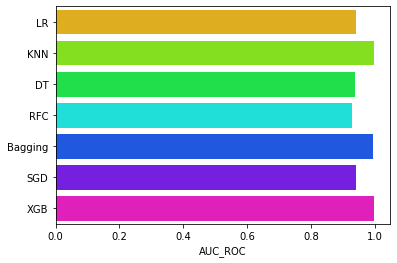

In [47]:
# 可视化 AUC的评分
g = sns.barplot('AUC_ROC', result_df.index, data=result_df, palette='hsv', orient='h')

#### X_new_2_test, y_new_2_test

In [48]:
result_df_2 = pd.DataFrame(columns=['Accuracy', 'F1-score', 'Recall', 'Precision', 'AUC_ROC'],
                         index=['LR','KNN','DT','RFC','Bagging','SGD','XGB'])

In [49]:
# 将所有最优超参数的模型放在一起
best_models = [LR_best_estimator, KNN_best_estimator, DT_best_estimator, RFC_best_estimator,
               BAG_best_estimator, SGD_best_estimator, XGB_best_estimator]

# 调用函数计算各项指标值
accuracy_results, F1_score_results, Recall_results, AUC_ROC_results, Precision_results = caculate(best_models, X_new_2_test, y_new_2_test)

# 将各项值放入到DataFrame中
result_df_2['Accuracy'] = accuracy_results
result_df_2['F1-score'] = F1_score_results
result_df_2['Recall'] = Recall_results
result_df_2['Precision'] = Precision_results
result_df_2['AUC_ROC'] = AUC_ROC_results

In [51]:
result_df_2

,Accuracy,F1-score,Recall,Precision,AUC_ROC
LR,0.958685,"[0.9696781965238341, 0.9351872287206651]","[0.9906469760900141, 0.8947072072072072]","[0.9495786990225817, 0.9795037756202805]",0.942677
KNN,0.998546,"[0.9989087965081489, 0.9978228808202824]","[0.9978199718706048, 1.0]","[1.0, 0.9956552207428171]",0.998910
DT,0.954746,"[0.9666839288796824, 0.9294745304392311]","[0.9845288326300985, 0.8951295045045045]","[0.9494743981010512, 0.9665602675178598]",0.939829
RFC,0.953198,"[0.9660544217687075, 0.9246678743961353]","[0.9986638537271448, 0.8621903153153153]","[0.9355072463768116, 0.9969075520833334]",0.930427
Bagging,0.996905,"[0.9976807927472064, 0.9953488372093023]","[0.9983122362869198, 0.9940878378378378]","[0.9970501474926253, 0.9966130397967824]",0.996200
SGD,0.956856,"[0.9682144831398563, 0.9328663164039698]","[0.9853727144866385, 0.8997747747747747]","[0.9516435751154577, 0.9684848484848485]",0.942574
XGB,0.999156,"[0.9993667323388685, 0.9987345331833523]","[0.9988045007032349, 0.9998592342342343]","[0.9999295972965362, 0.9976123595505618]",0.999332


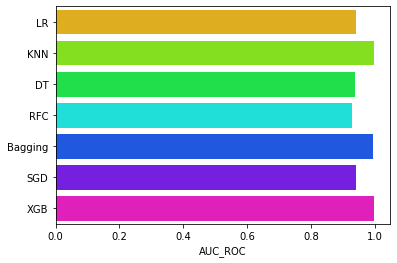

In [50]:
# 可视化 AUC的评分
g = sns.barplot('AUC_ROC', result_df_2.index, data=result_df_2, palette='hsv', orient='h')

In [53]:
# 集成学习

# 根据以上AUC的结果,选择: LR 和 SVC 和 XGB 当做基模型

KNN_test = pd.Series(KNN_best_estimator.predict(X_new_1_test), name = 'KNN')

Bagging_test = pd.Series(BAG_best_estimator.predict(X_new_1_test),name = 'Bagging')

XGB_test = pd.Series(XGB_best_estimator.predict(X_new_1_test), name='XGB')

In [54]:
# 把以上3个模型的预测结果集成起来
ensemble_results = pd.concat([KNN_test, Bagging_test, XGB_test], axis=1)

In [55]:
ensemble_results

,KNN,Bagging,XGB
0,1,1,1
1,0,0,0
2,0,0,0
3,1,1,1
4,0,0,0
...,...,...,...
142153,1,1,1
142154,1,1,1
142155,0,0,0
142156,0,0,0


In [56]:
# 将上述3个模型集成起来，当做一个模型
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('KNN', KNN_best_estimator), ('BAG', BAG_best_estimator), 
                                          ('XGB', XGB_best_estimator)], n_jobs=-1)

In [57]:
# 训练
voting_clf.fit(X_new_1_train, y_new_1_train)

VotingClassifier(estimators=[('KNN', KNeighborsClassifier(n_neighbors=2)),
                             ('BAG', BaggingClassifier(n_estimators=20)),
                             ('XGB',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                 

In [58]:
# 预测
y_final_pred = voting_clf.predict(X_new_1_test)

In [59]:
# 评估结果 ： 最终集成学习预测的结果明显高于之前各个模型单独预测的结果

print(classification_report(y_new_1_test, y_final_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71093
           1       1.00      1.00      1.00     71065

    accuracy                           1.00    142158
   macro avg       1.00      1.00      1.00    142158
weighted avg       1.00      1.00      1.00    142158



### 绘制学习曲线

### 用整个新的数据集进行交叉验证训练，并绘制学习曲线

In [60]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(models, names, X, y, ylim=None, cv=None, n_jobs=-1):
    f, ax = plt.subplots(8, 1, figsize=(20, 50))
    if ylim is not None:
        plt.ylim(*ylim)
    for i in range(len(models)):
        train_sizes, train_scores, test_scores = learning_curve(models[i], X, y, cv=cv, n_jobs=n_jobs)

        train_scores_mean = np.mean(train_scores, axis=1)

        test_scores_mean = np.mean(test_scores, axis=1)

        ax[i].plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label='Training score')
        ax[i].plot(train_sizes, test_scores_mean, '+-', color='#2492ff', label='cross-validation score')

        ax[i].set_title(names[i], fontsize=14)
        ax[i].set_xlabel('Training size(m)')
        ax[i].set_ylabel('Score')
        ax[i].grid(True)
        ax[i].legend(loc='best')

In [61]:
cv = ShuffleSplit(n_splits=5, random_state=666, test_size=0.2) # 切分的比例

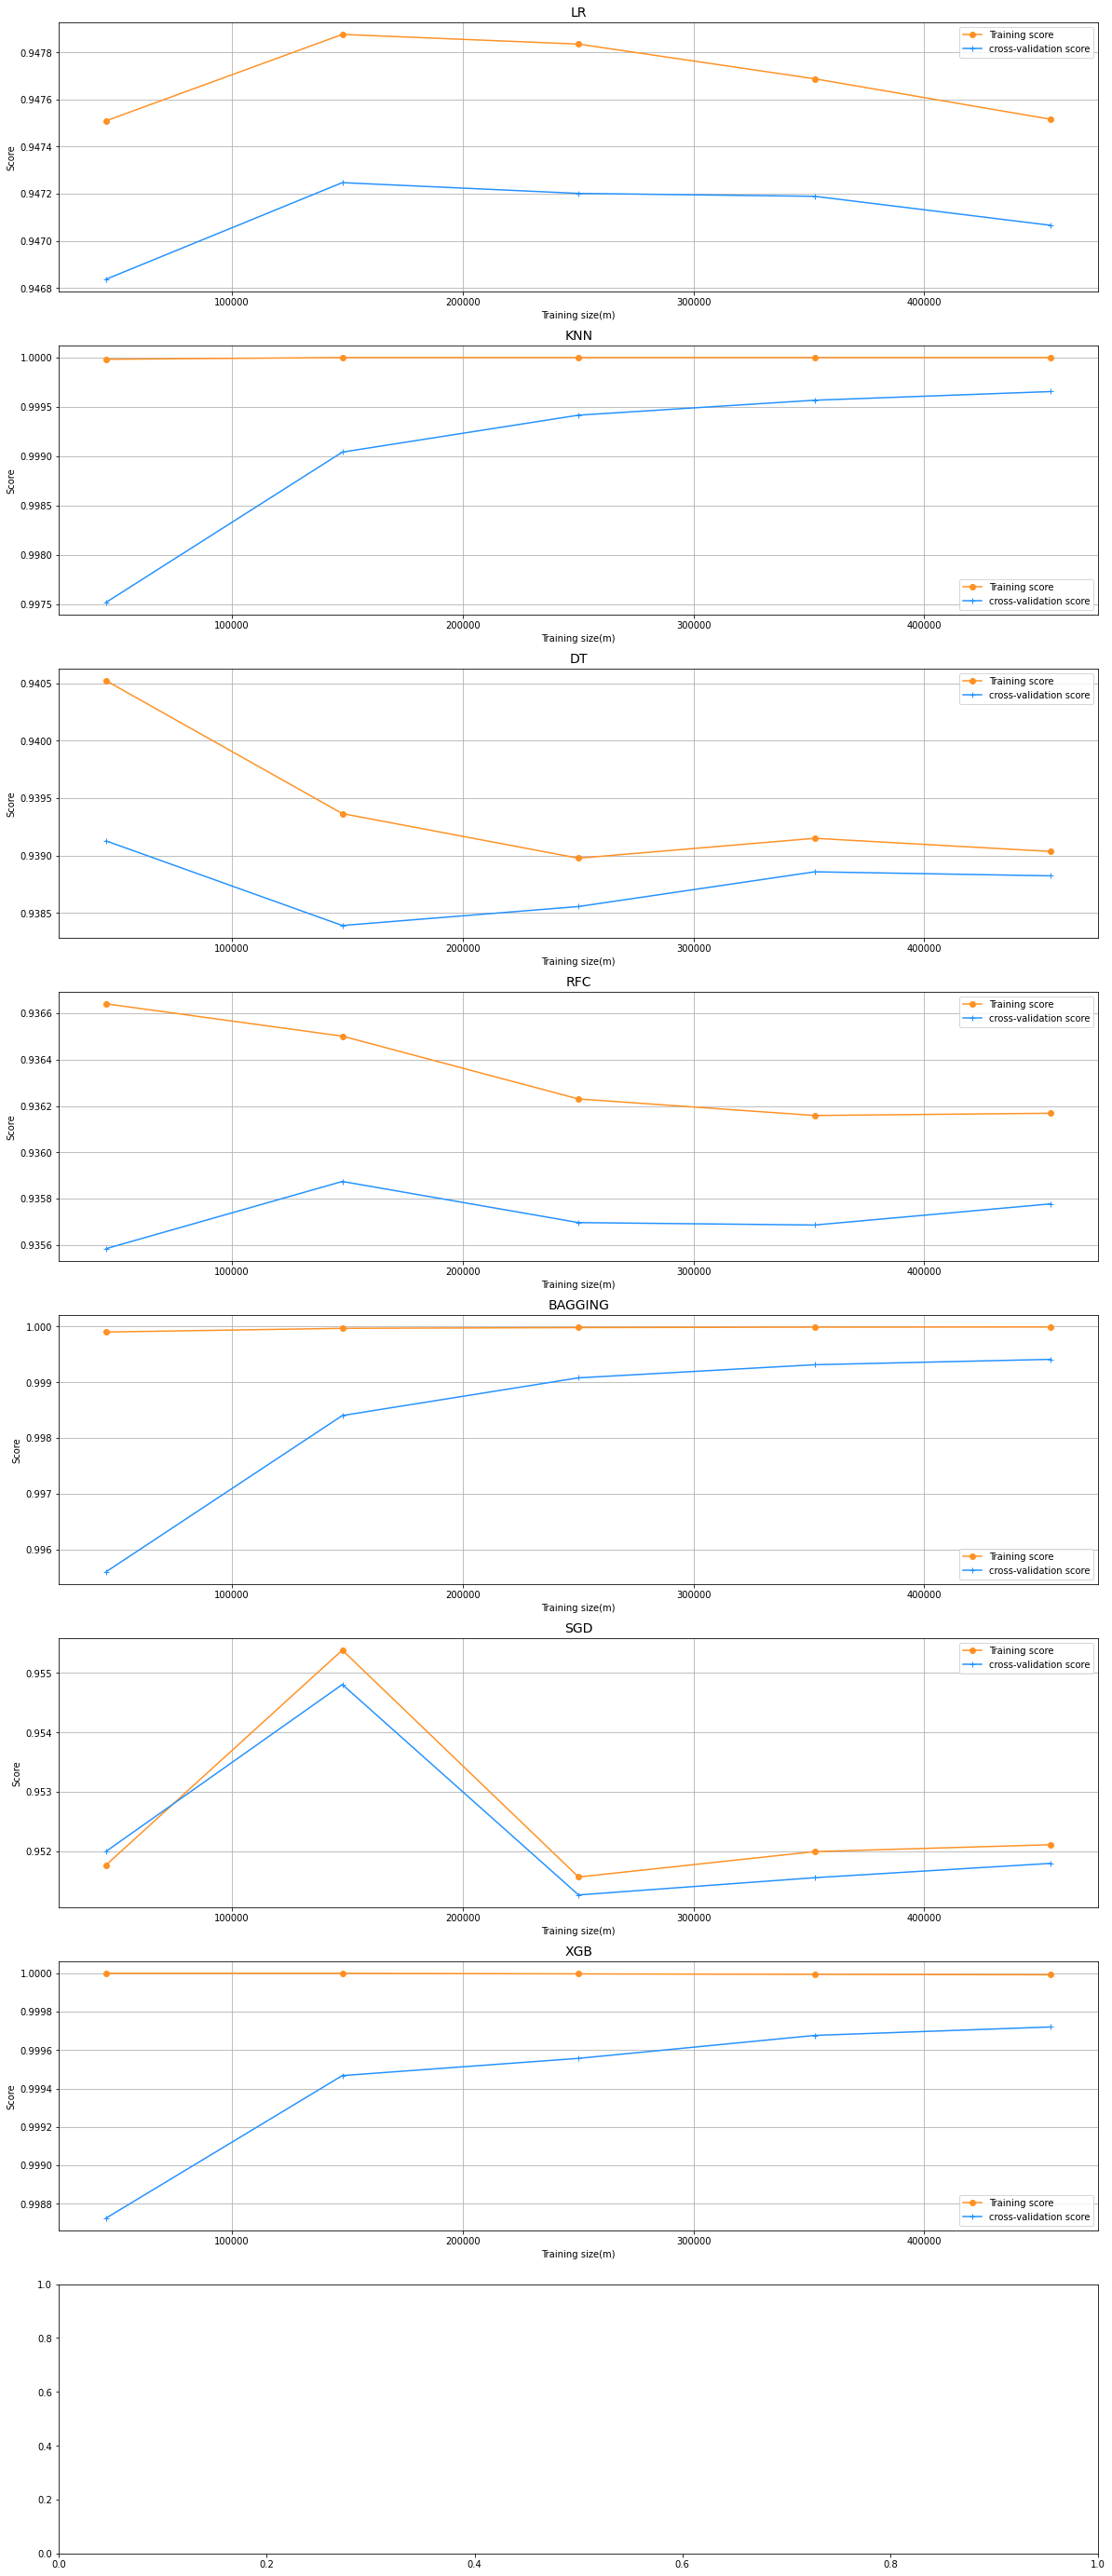

In [63]:
# 绘制各个模型的学习曲线 【X_new_1】
best_models = [LR_best_estimator, KNN_best_estimator, DT_best_estimator, RFC_best_estimator,
               BAG_best_estimator, SGD_best_estimator, XGB_best_estimator]

names = ['LR', 'KNN', 'DT', 'RFC', 'BAGGING', 'SGD', 'XGB']

plot_learning_curve(best_models, names, X_new_1, y_new_1, cv=cv)

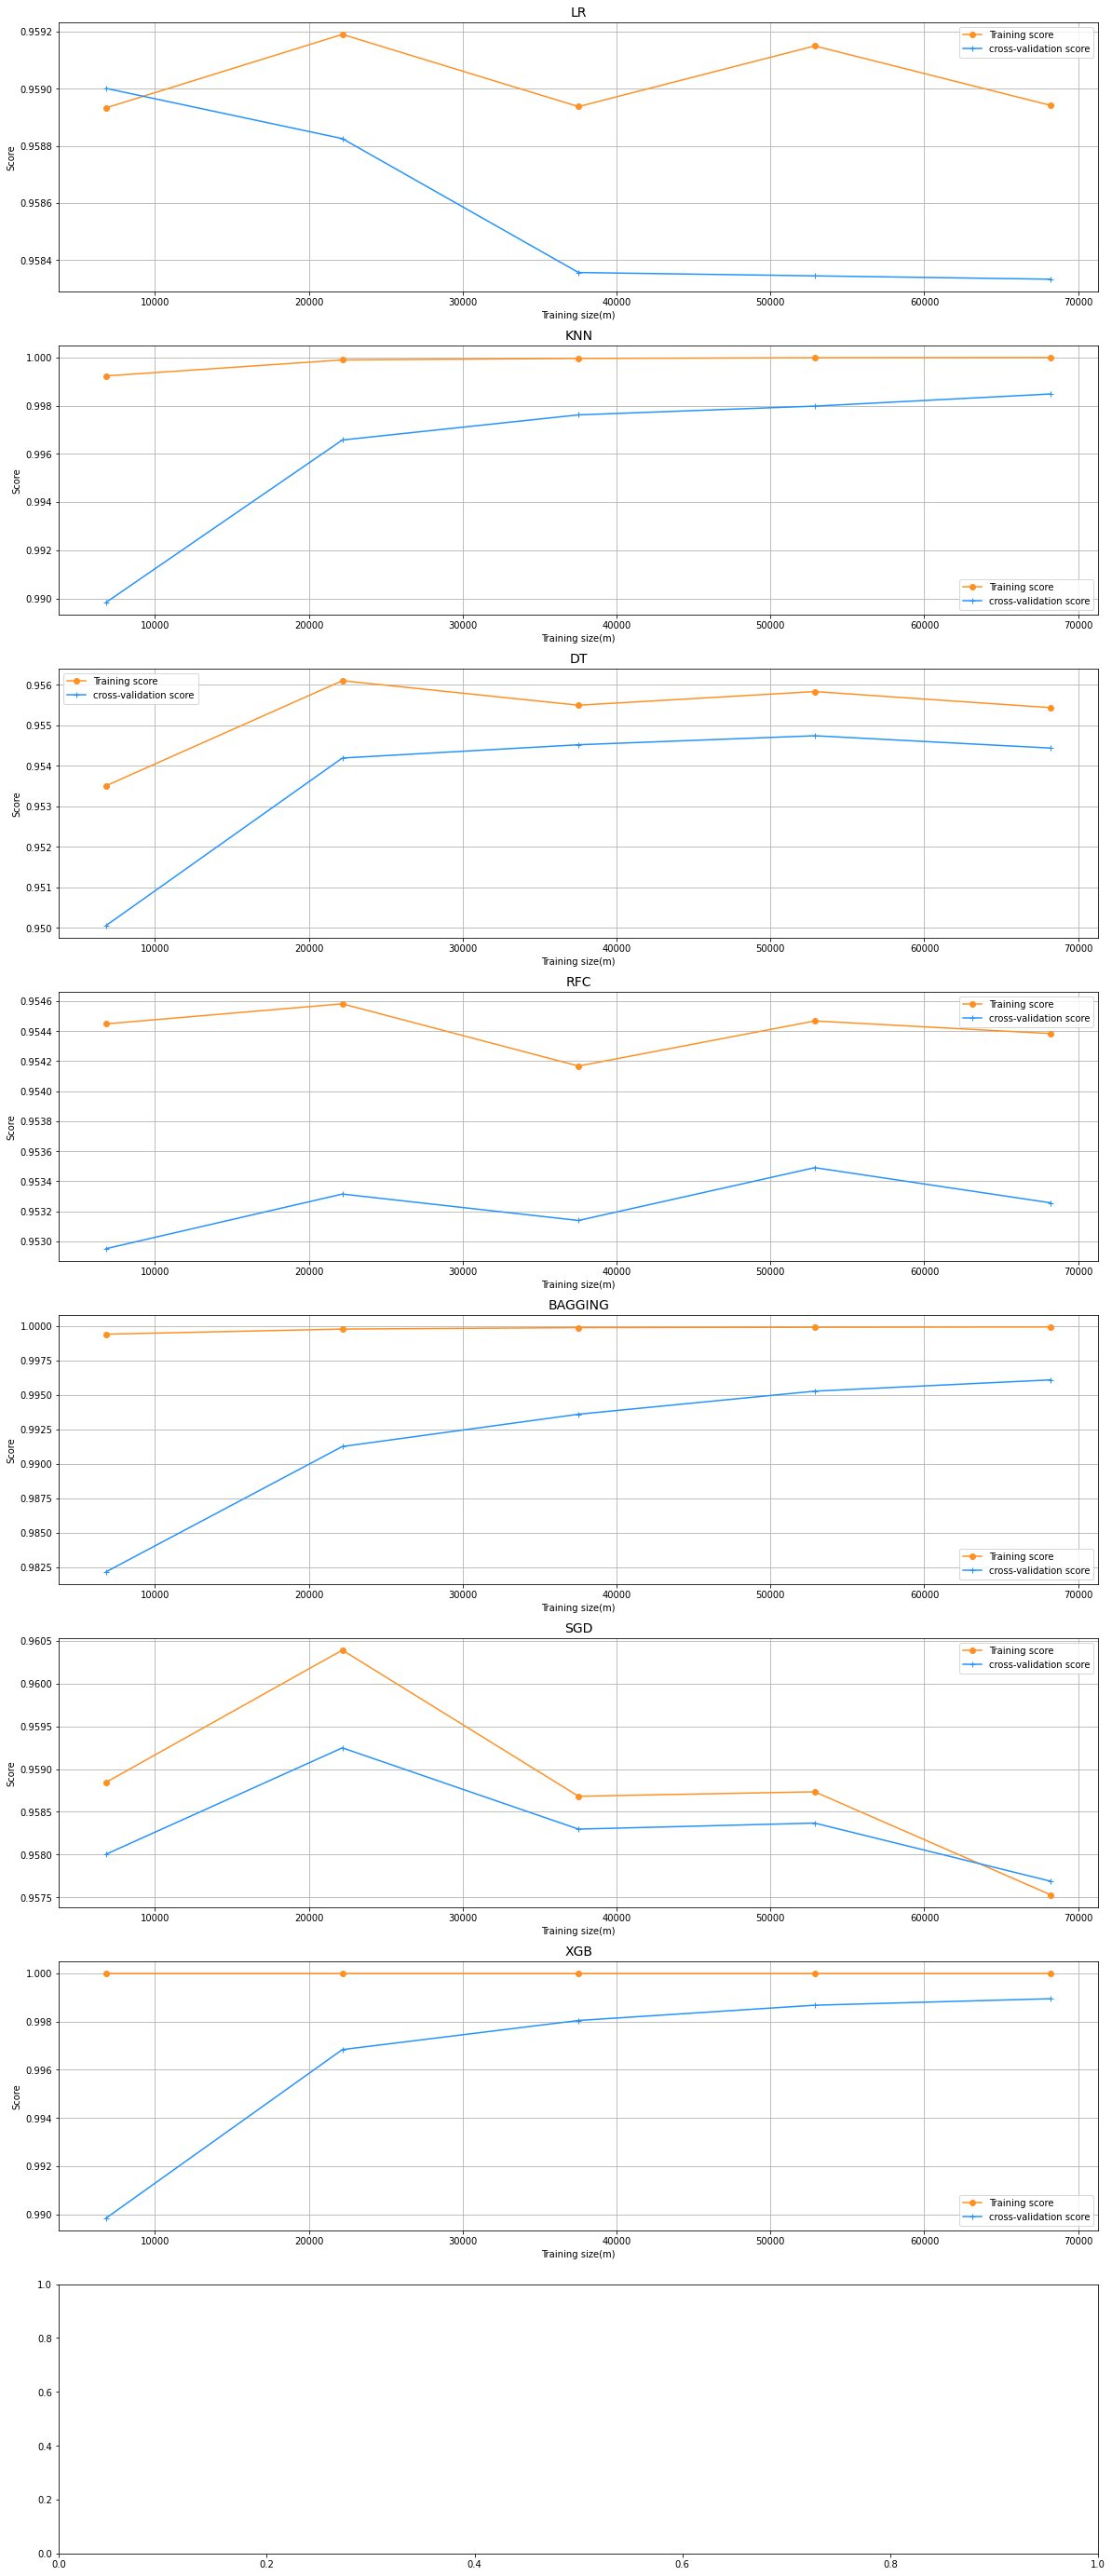

In [65]:
# 绘制各个模型的学习曲线 【X_new_2】
best_models = [LR_best_estimator, KNN_best_estimator, DT_best_estimator, RFC_best_estimator,
               BAG_best_estimator, SGD_best_estimator, XGB_best_estimator]

names = ['LR', 'KNN', 'DT', 'RFC', 'BAGGING', 'SGD', 'XGB']

plot_learning_curve(best_models, names, X_new_2, y_new_2, cv=cv)

### 绘制ROC曲线

In [66]:
from sklearn.model_selection import cross_val_predict

LR_pred = cross_val_predict(LR_best_estimator, X_new_1, y_new_1, cv=5)
KNN_pred = cross_val_predict(KNN_best_estimator, X_new_1, y_new_1, cv=5)
DT_pred = cross_val_predict(DT_best_estimator, X_new_1, y_new_1, cv=5)
RFC_pred = cross_val_predict(RFC_best_estimator, X_new_1, y_new_1, cv=5)
BAG_pred = cross_val_predict(BAG_best_estimator, X_new_1, y_new_1, cv=5)
SGD_pred = cross_val_predict(SGD_best_estimator, X_new_1, y_new_1, cv=5)
XGB_pred = cross_val_predict(XGB_best_estimator, X_new_1, y_new_1, cv=5)

In [77]:
# 计算auc的评分
print('LR roc_auc_score :', roc_auc_score( y_new_1, LR_pred))
print('KNN roc_auc_score :', roc_auc_score( y_new_1, KNN_pred))
print('DT roc_auc_score :', roc_auc_score( y_new_1, DT_pred))
print('RFC_score :', roc_auc_score(y_new_1, RFC_pred))
print('BAG_score :', roc_auc_score( y_new_1, BAG_pred))
print('SGD_score :', roc_auc_score( y_new_1, SGD_pred))
print('XGB_score :', roc_auc_score( y_new_1, XGB_pred))

LR roc_auc_score : 0.9381249670260098
KNN roc_auc_score : 0.9978879060197317
DT roc_auc_score : 0.8998171042681533
RFC_score : 0.9322037177074722
BAG_score : 0.7873977806306387
SGD_score : 0.9450451084184796
XGB_score : 0.921349559467492


In [78]:
# 计算每个模型的 fpr, tpr
from sklearn.metrics import roc_curve

LR_fpr, LR_tpr, LR_threshold = roc_curve( y_new_1, LR_pred)

KNN_fpr, KNN_tpr, KNN_threshold = roc_curve(y_new_1, KNN_pred)

DT_fpr, DT_tpr, DT_threshold = roc_curve(y_new_1, DT_pred)

RFC_fpr, RFC_tpr, RFC_threshold = roc_curve(y_new_1, RFC_pred)

BAG_fpr, BAG_tpr, BAG_threshold = roc_curve(y_new_1, BAG_pred)

SGD_fpr, SGD_tpr, SGD_threshold = roc_curve(y_new_1, SGD_pred)

XGB_fpr, XGB_tpr, XGB_threshold = roc_curve(y_new_1, XGB_pred)

In [79]:
# 绘制roc曲线
def graph_roc(fpr, tpr, name, score):
    plt.figure(figsize=(16,8)) # 画布大小
    plt.title("ROC Curve", fontsize=14)
    plt.plot(fpr, tpr, label=name+":"+ str(score))
    plt.axis([-0.01, 1, 0, 1]) # 坐标轴
    plt.xlabel("False Positive Rate (FPR)", fontsize=14)
    plt.ylabel("True Positive Rate (TPR)", fontsize=14)
    plt.legend()
    plt.show()

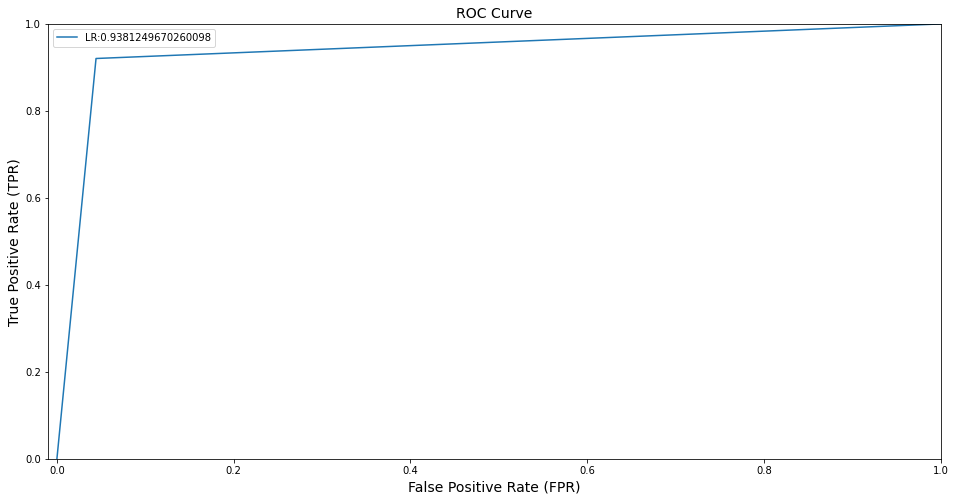

In [80]:
# 1 LR AUC
graph_roc(LR_fpr, LR_tpr, 'LR', roc_auc_score(y_new_1, LR_pred))

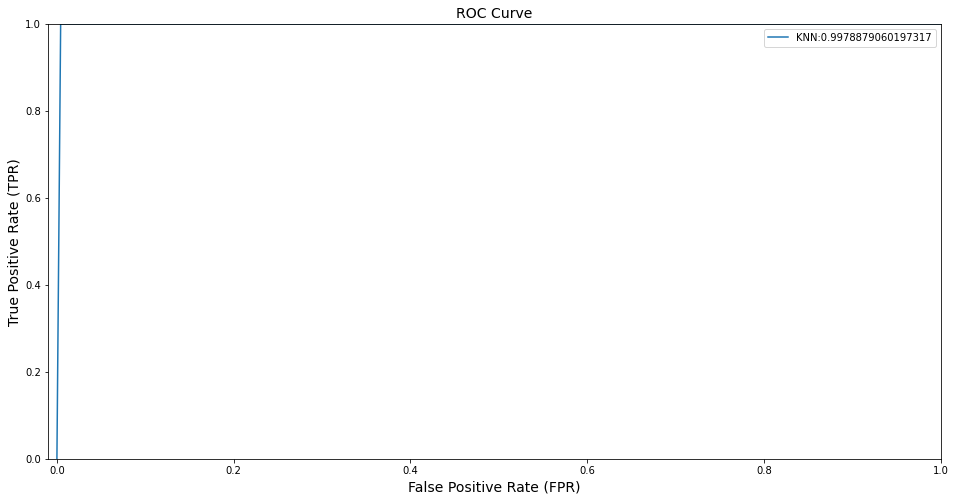

In [81]:
# 2 KNN AUC
graph_roc(KNN_fpr, KNN_tpr, 'KNN', roc_auc_score(y_new_1, KNN_pred))

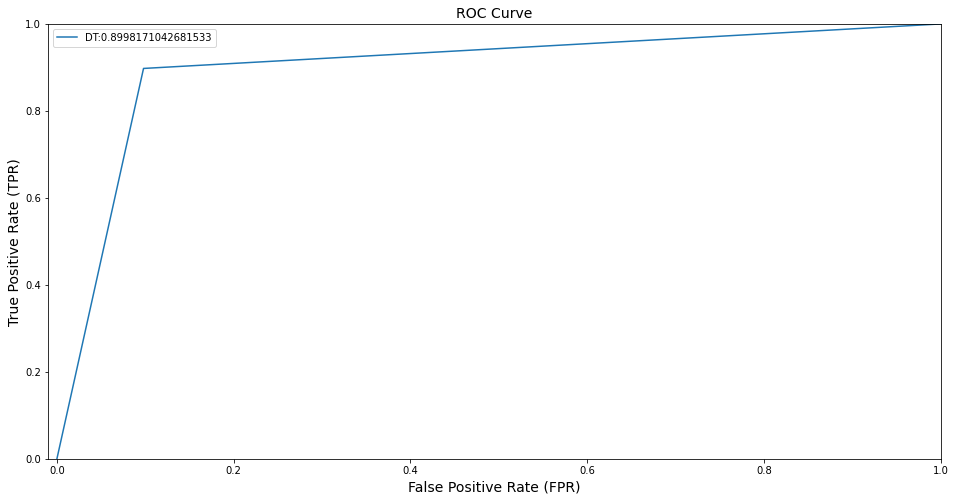

In [82]:
# 3 DT AUC
graph_roc(DT_fpr, DT_tpr, 'DT', roc_auc_score(y_new_1, DT_pred))

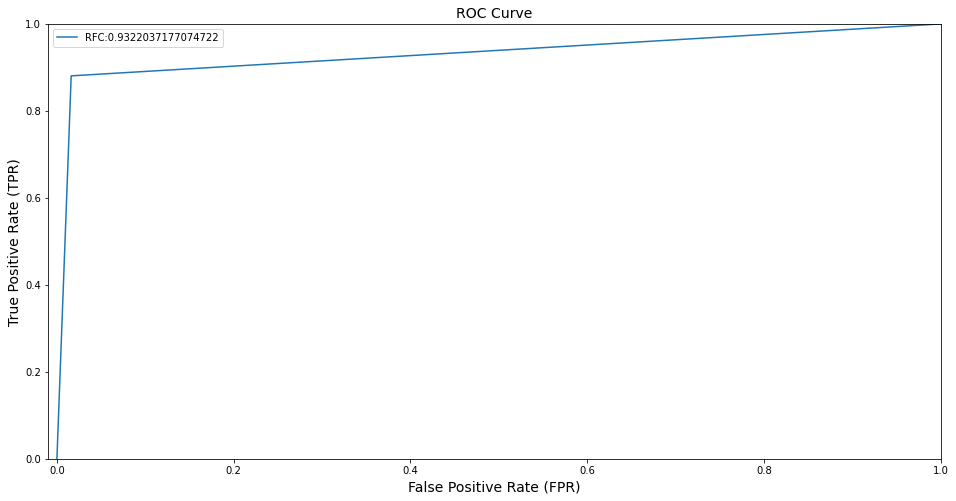

In [83]:
# 4 RFC AUC
graph_roc(RFC_fpr, RFC_tpr, 'RFC', roc_auc_score(y_new_1, RFC_pred))

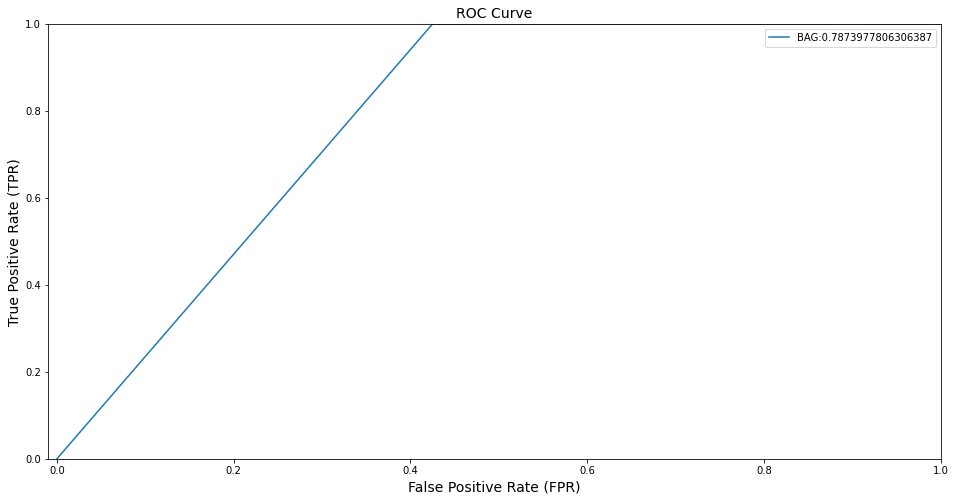

In [84]:
# 5 BAG AUC
graph_roc(BAG_fpr,BAG_tpr, 'BAG', roc_auc_score(y_new_1, BAG_pred))

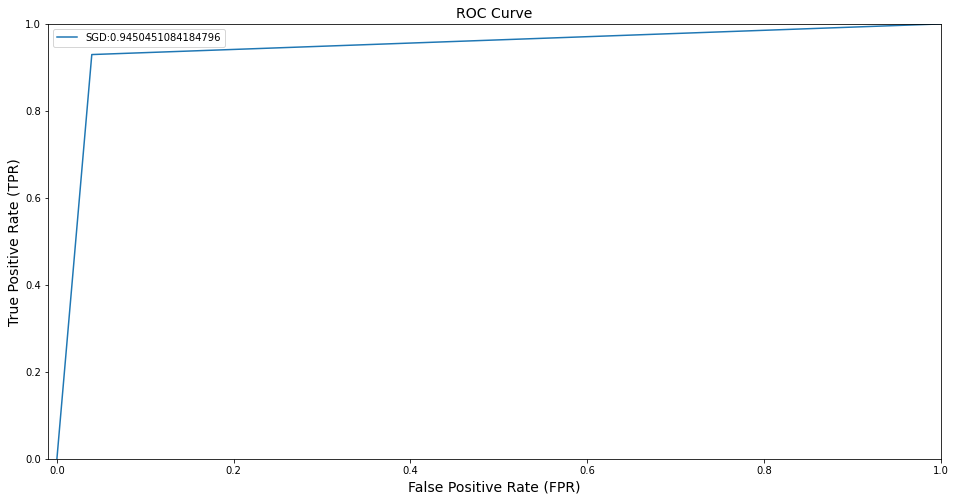

In [85]:
# 6 SGD AUC
graph_roc(SGD_fpr, SGD_tpr, 'SGD', roc_auc_score(y_new_1, SGD_pred))

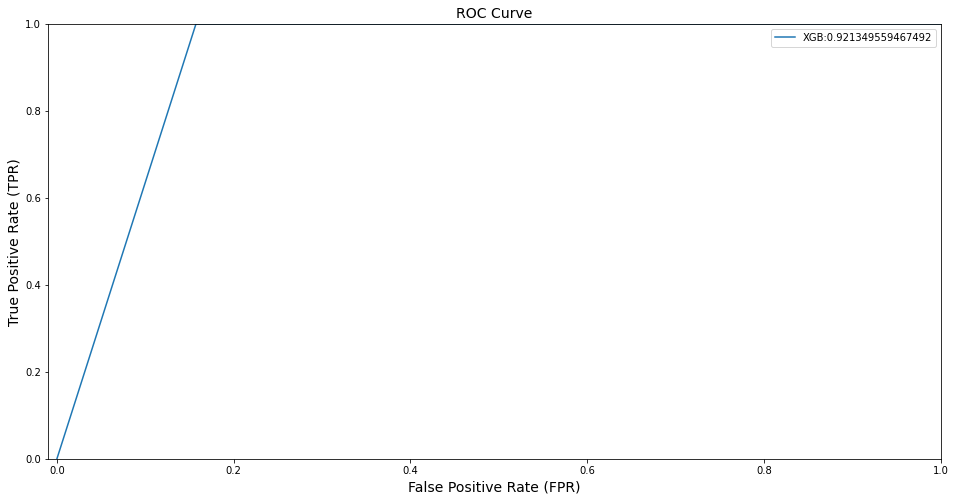

In [86]:
# 7 XGB AUC
graph_roc(XGB_fpr, XGB_tpr, 'XGB', roc_auc_score(y_new_1, XGB_pred))